# Multi-output GP

We follow this GPyTorch example/tutorial which is based on Bonilla 2007. 

https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

We have a free form matrix that is multiplied by the covariance matrix
https://predictivesciencelab.github.io/data-analytics-se/lecture22/hands-on-22.3.html 

In [1]:
# download to /home/kim/mass_balance_ConvNP/.conda-deepsensor conda environment
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
# Avoiding Restarting the Kernel, if we are working in a module (.py file) (because we are developing it for example) it is updated
%load_ext autoreload
%autoreload 2
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.

## Replicate example

In [23]:
# Input space
train_x = torch.linspace(0, 1, 100)
# train_x = torch.linspace(0, 2, 200)

# sine and cosine functions
# uncorrelated: 0 MO correlation coef
train_y = torch.stack([
   torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.4,
   torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.4,
], -1)


# Same: 1 MO correlation coef
"""
train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)
"""

# sine and -sine functions
# -1 MO correlation coef
"""
train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    -1*(torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2),
 ], -1)
"""

# Test Bonilla property: zero noise
# sine and sine dependent but no noise
# shifted and inflated sine function: 1 MO corr coef (perfect corr)
"""
train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.0,
    1 + (1.1*(torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.0)),
], -1)
"""

# 2-output GP
print(train_y.shape)
print("mean values:")
print(train_y.mean(dim = 0))

torch.Size([100, 2])
mean values:
tensor([0.0497, 0.0093])


In [25]:
# Correlation coefficient
torch.corrcoef(train_y.T)

tensor([[ 1.0000, -0.0024],
        [-0.0024,  1.0000]])

## Intrinsic model of coregionalization (ICM)

In [26]:
# Initialise an exact GP model
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)

        # Wrap mean in multitask mean
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks = 2
        )
        # self.mean_module = gpytorch.means.MultitaskMean(
        #    gpytorch.means.ConstantMean(), num_tasks = 2
        #)

        # Already does scaling for us
        # Full rank: number of tasks
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks = 2, rank = 2
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# cross-task covariance structure (is the noise correlated?) for the noise or independent noise for each task
# rank = 0: strictly diagonal noise (This is the default.) But individual noise for each task.
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks = 2, rank = 0)
model = MultitaskGPModel(train_x, train_y, likelihood)

## Training

- 50 iterations
- ConstantMean() reaches - 0.096 likelihood

In [27]:
# this is for running the notebook in our testing framework
import os
# Continuous Integration (CI) environment
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 100 # pretty much stagnates after 50 iterations

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = - mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 1.230
Iter 2/100 - Loss: 1.197
Iter 3/100 - Loss: 1.165
Iter 4/100 - Loss: 1.132
Iter 5/100 - Loss: 1.098
Iter 6/100 - Loss: 1.064
Iter 7/100 - Loss: 1.030
Iter 8/100 - Loss: 0.995
Iter 9/100 - Loss: 0.961
Iter 10/100 - Loss: 0.928
Iter 11/100 - Loss: 0.896
Iter 12/100 - Loss: 0.865
Iter 13/100 - Loss: 0.834
Iter 14/100 - Loss: 0.803
Iter 15/100 - Loss: 0.773
Iter 16/100 - Loss: 0.744
Iter 17/100 - Loss: 0.716
Iter 18/100 - Loss: 0.690
Iter 19/100 - Loss: 0.666
Iter 20/100 - Loss: 0.644
Iter 21/100 - Loss: 0.625
Iter 22/100 - Loss: 0.609
Iter 23/100 - Loss: 0.595
Iter 24/100 - Loss: 0.584
Iter 25/100 - Loss: 0.575
Iter 26/100 - Loss: 0.570
Iter 27/100 - Loss: 0.566
Iter 28/100 - Loss: 0.566
Iter 29/100 - Loss: 0.566
Iter 30/100 - Loss: 0.569
Iter 31/100 - Loss: 0.572
Iter 32/100 - Loss: 0.575
Iter 33/100 - Loss: 0.579
Iter 34/100 - Loss: 0.582
Iter 35/100 - Loss: 0.584
Iter 36/100 - Loss: 0.585
Iter 37/100 - Loss: 0.585
Iter 38/100 - Loss: 0.584
Iter 39/100 - Loss: 0

# Make predictions

Text(0.5, 1.0, 'Observed Values (Likelihood)')

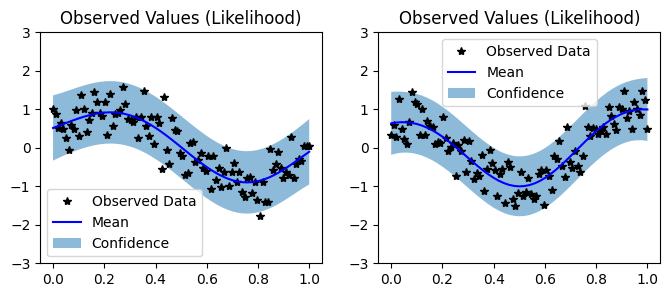

In [28]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

## Parameters and their meaning

In [29]:
# Assume model is your trained GPyTorch model
for name, param in model.named_parameters():
    print(f"Parameter: {name}, Value: {param.data}")

Parameter: likelihood.raw_task_noises, Value: tensor([-2.4611, -2.6346])
Parameter: likelihood.raw_noise, Value: tensor([-2.5475])
Parameter: covar_module.task_covar_module.covar_factor, Value: tensor([[ 0.2407,  0.2853],
        [ 0.3431, -0.2353]])
Parameter: covar_module.task_covar_module.raw_var, Value: tensor([-0.8160, -0.3650])
Parameter: covar_module.data_covar_module.raw_lengthscale, Value: tensor([[-1.2503]])


### model.likelihood.task_noise_covar_factor
- likelihood.task_noise_covar_factor: (when likelihood rank = 1 [2, 1], rank = 2: [2, 2], rank = 3: [2, 3]: full rank?!)  
OR
- likelihood.raw_task_noises: individual noise levels (when likelihood rank = 0 [2, 1])
- likelihood.raw_noise: diag(softplus(likelihood.raw_noise)) - somewhat redundant

### model.covar_module.task_covar_module.covar_factor
- covar_module.task_covar_module.covar_factor: dim of tasks, "square root of K_t"
- covar_module.task_covar_module.raw_var: dim of tasks, additional diagonal variance

Data covariance:
- covar_module.data_covar_module.raw_lengthscale: shared, in base covaraince kernel, 

### Noise (co-)variance matrix

In [30]:
# noise covaraince case:
# same as torch.nn.functional.softplus(model.likelihood.raw_noise)
# print("Cross-noise matrix:")
# noise_covar = model.likelihood.task_noise_covar_factor.matmul(model.likelihood.task_noise_covar_factor.transpose(-1, -2)).detach()

print("Noise task matrix:")
# don"t use raw
noise_ma = torch.diag_embed(model.likelihood.task_noises.detach())
print(noise_ma)

print()
print("Added shared diagonal noise:")
D = model.likelihood.noise.detach() * torch.eye(2)
print(D)

print()
print("Combined noise:")
print(noise_ma + D)

Noise task matrix:
tensor([[0.0820, 0.0000],
        [0.0000, 0.0694]])

Added shared diagonal noise:
tensor([[0.0755, 0.0000],
        [0.0000, 0.0755]])

Combined noise:
tensor([[0.1575, 0.0000],
        [0.0000, 0.1449]])


### Task-covariance (coregionalization matrix)

- Sine and - Sine: -1.1 cross-covaraince (off-diagonal negative values are ok) (same magnitude as variance)
- W shape depends on the rank 

In [31]:
print("Cross-task covariance matrix:")
# Covar_factor itself is "like the square root" because we compose the matrix using (W (column vector) W^T (row vector)) (OUTER product) W may also be a matrix of shape task, rank
print(model.covar_module.task_covar_module.covar_factor.data.matmul(model.covar_module.task_covar_module.covar_factor.data.transpose(-1, -2)))
# Same as
# print(model.covar_module.task_covar_module.covar_factor.data * model.covar_module.task_covar_module.covar_factor.data.T)

print()
print("Diagonal noise:")
print(torch.diag_embed(torch.nn.functional.softplus(model.covar_module.task_covar_module.raw_var.data)))
# Add raw variance to the diagonal
# torch.nn.Softplus(model.covar_module.task_covar_module.raw_var.data) 

print()
print("Cross-task covariance matrix with diagonal noise added:")
B = model.covar_module.task_covar_module.covar_factor.data.matmul(model.covar_module.task_covar_module.covar_factor.data.transpose(-1, -2)) + torch.diag_embed(torch.nn.functional.softplus(model.covar_module.task_covar_module.raw_var.data))
print(B)

print()
# model.covar_module.task_covar_module.var
print("Correlation coefficient between tasks:")
corr_coeff = B[0,1] / torch.sqrt(B[0,0] * B[1,1])
print(corr_coeff)

Cross-task covariance matrix:
tensor([[0.1394, 0.0155],
        [0.0155, 0.1731]])

Diagonal noise:
tensor([[0.3662, 0.0000],
        [0.0000, 0.5272]])

Cross-task covariance matrix with diagonal noise added:
tensor([[0.5055, 0.0155],
        [0.0155, 0.7003]])

Correlation coefficient between tasks:
tensor(0.0260)


In [32]:
# Softplus is correct
print(torch.nn.functional.softplus(model.covar_module.task_covar_module.raw_var.data))
# print(torch.exp(model.covar_module.task_covar_module.raw_var.data))

# Test difference to exponential for larger values
# For small (negative) values of h, the exponential function is close to the exponential function
h = 0.0
print(torch.nn.functional.softplus(model.covar_module.task_covar_module.raw_var.data + h))
# print(torch.exp(model.covar_module.task_covar_module.raw_var.data + h))

tensor([0.3662, 0.5272])
tensor([0.3662, 0.5272])


In [33]:
model.covar_module.data_covar_module.raw_lengthscale

print("RBF base kernel lengthscale:")
print(torch.nn.functional.softplus(model.covar_module.data_covar_module.raw_lengthscale).item())
# Same as:
# https://predictivesciencelab.github.io/data-analytics-se/lecture22/hands-on-22.3.html 
print(f"length scale: {model.covar_module.data_covar_module.lengthscale.item():.3f}")

RBF base kernel lengthscale:
0.2518728971481323
length scale: 0.252


Information on parameters in the documentation:

gpytorch.likelihoods.multitask_gaussian_likelihood
https://docs.gpytorch.ai/en/stable/likelihoods.html#multi-dimensional-likelihoods
https://docs.gpytorch.ai/en/v1.11/_modules/gpytorch/likelihoods/multitask_gaussian_likelihood.html

gpytorch.kernels.MultitaskKernel
https://docs.gpytorch.ai/en/stable/kernels.html#multitaskkernel
uses look-up index kernel https://docs.gpytorch.ai/en/stable/kernels.html#indexkernel 
- model.covar_module.data_covar_module: base covariance module/data kernel
- Kronecker product
- raw_var is element-wise log of the v vector

gpytorch.means.MultitaskMean 
https://docs.gpytorch.ai/en/stable/means.html#gpytorch.means.MultitaskMean 
- can pass in a list of different mean functions to have a different mean for every task

### Very useful post
https://github.com/cornellius-gp/gpytorch/issues/715   
`K_{data} \kron (covar_factor * covar_factor^{T} + diag(softplus(raw_var))`
-  square root of the task covariance matrix
- model.task_covar_module.covar_matrix just comes out of nowhere

# From docs
    `def _eval_covar_matrix(self) -> Tensor:
        covar_factor = self.task_noise_covar_factor
        noise = self.noise
        D = noise * torch.eye(self.num_tasks, dtype=noise.dtype, device=noise.device)  # pyre-fixme[16]
        return covar_factor.matmul(covar_factor.transpose(-1, -2)) + D`

- https://github.com/cornellius-gp/gpytorch/issues/594
- https://github.com/cornellius-gp/gpytorch/issues/1692

Issues:

- For a zero noise case the cross-covar does not collapse to zero